In [2]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
print(tf.__version__)

import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
from matplotlib import offsetbox
import numpy as np
from tqdm import tqdm

import glob
import ntpath
import cv2

from sklearn.metrics.pairwise import cosine_similarity
from sklearn import manifold
import scipy as sc

2.10.0


# Load Images

Found [30] images


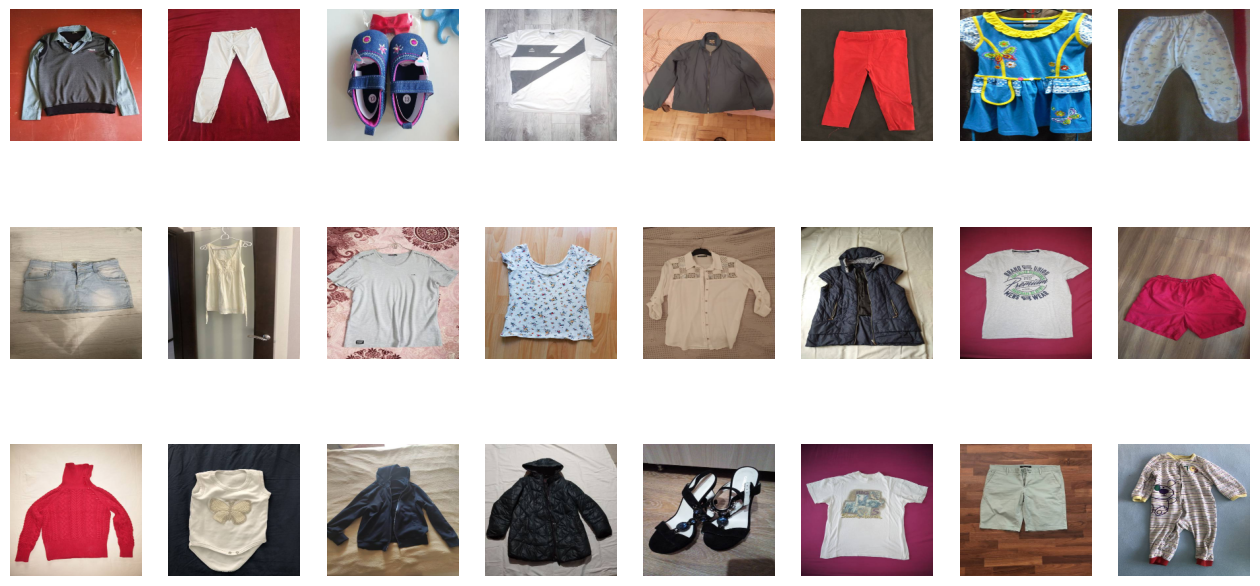

In [3]:
image_paths = glob.glob('/Users/jiaohongmei/info7374/assign2/clothing-dataset-master/images1/*.jpg')
print(f'Found [{len(image_paths)}] images')

images = {}
for image_path in image_paths:
    
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    images[ntpath.basename(image_path)] = image
    


n_col = 8
n_row = int(len(images)/n_col)
f, ax = plt.subplots(n_row, n_col, figsize=(16, 8))
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(list(images.values())[n_col*i + j])
        ax[i, j].set_axis_off()

In [4]:
def load_image(image):
    image = plt.imread(image)
    img = tf.image.convert_image_dtype(image, tf.float32)
    img = tf.image.resize(img, [400, 400])
    img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d)
    return img

#
# content layers describe the image subject
#
content_layers = ['block5_conv2'] 

#
# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
#
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 

def selected_layers_model(layer_names, baseline_model):
    outputs = [baseline_model.get_layer(name).output for name in layer_names]
    model = Model([vgg.input], outputs)
    return model

# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

class StyleModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleModel, self).__init__()
        self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    def call(self, inputs):
        # scale back the pixel values
        inputs = inputs*255.0
        # preprocess them with respect to VGG19 stats
        preprocessed_input = preprocess_input(inputs)
        # pass through the reduced network
        outputs = self.vgg(preprocessed_input)
        # segregate the style and content representations
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # calculate the gram matrix for each layer
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        # assign the content representation and gram matrix in
        # a layer by layer fashion in dicts
        content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()]) 

#
# Print shapes of the style layers and embeddings
#
image_tensor = load_image(image_paths[0])
style_tensors = image_to_style(image_tensor)
for k,v in style_tensors.items():
    print(f'Style tensor {k}: {v.shape}')
style_embedding = style_to_vec( style_tensors )
print(f'Style embedding: {style_embedding.shape}')

#
# compute styles
#
image_style_embeddings = {}
for image_path in tqdm(image_paths): 
    image_tensor = load_image(image_path)
    style = style_to_vec( image_to_style(image_tensor) )
    image_style_embeddings[ntpath.basename(image_path)] = style


2022-10-24 21:54:08.588730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Style tensor block1_conv1: (1, 64, 64)
Style tensor block2_conv1: (1, 128, 128)
Style tensor block3_conv1: (1, 256, 256)
Style embedding: (86016,)


100%|███████████████████████████████████████████| 30/30 [00:37<00:00,  1.24s/it]


In [5]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


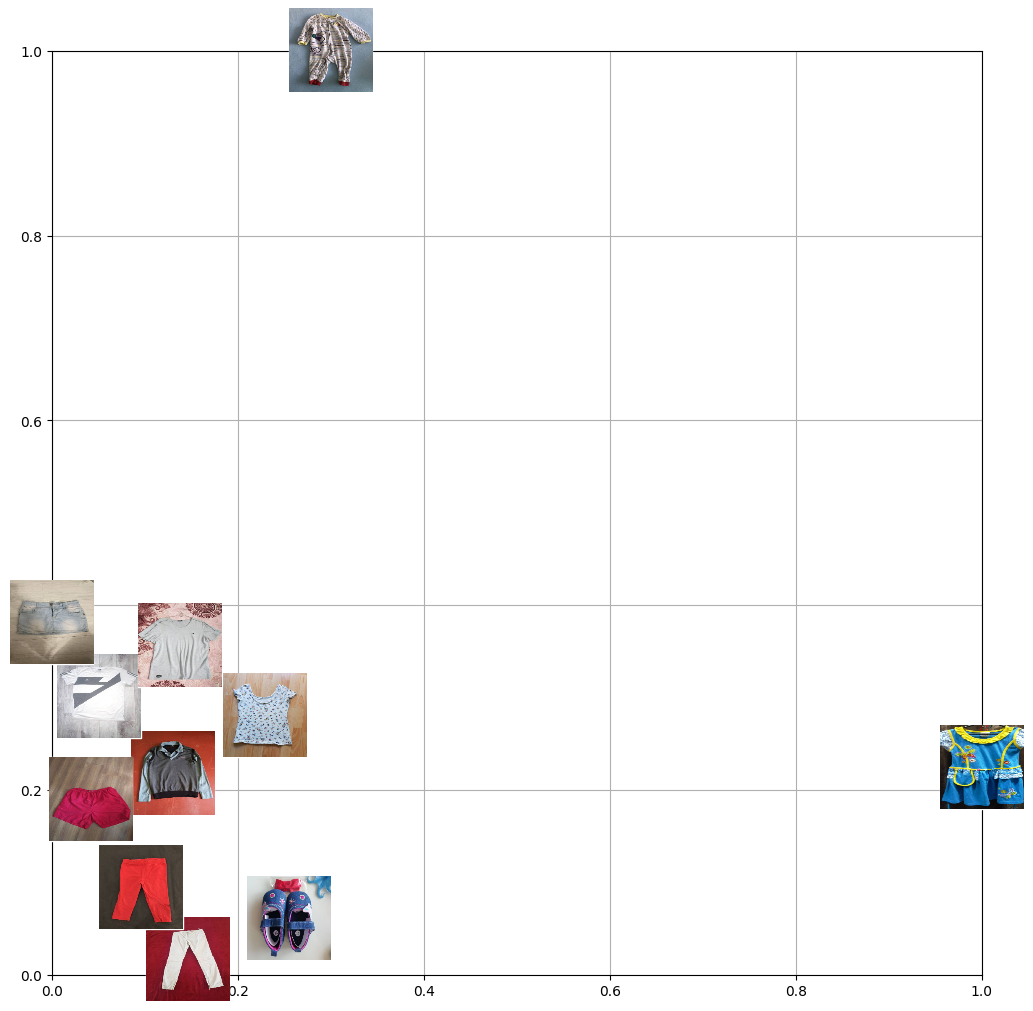

In [6]:
#
# Visualize the 2D-projection of the embedding space with example images (thumbnails)
#
def embedding_plot(X, images, thumbnail_sparsity = 0.005, thumbnail_size = 0.3):
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    X = (X - x_min) / (x_max - x_min)
    fig, ax = plt.subplots(1, figsize=(12, 12))

    shown_images = np.array([[1., 1.]])
    for i in range(X.shape[0]):
        if np.min(np.sum((X[i] - shown_images) ** 2, axis=1)) < thumbnail_sparsity: continue
        shown_images = np.r_[shown_images, [X[i]]]
        thumbnail = offsetbox.OffsetImage(images[i], cmap=plt.cm.gray_r, zoom=thumbnail_size)
        ax.add_artist(offsetbox.AnnotationBbox(thumbnail, X[i], bboxprops = dict(edgecolor='white'), pad=0.0))

    plt.grid(True)
    
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=10, random_state=0)
X_tsne = tsne.fit_transform( np.array(list(image_style_embeddings.values())) )
embedding_plot(X_tsne, images=list(images.values()))

0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg
0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg
0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg
0a1955a3-c4c5-4141-8a72-afbcf92d0dfa.jpg
0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg
0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg
0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg
0add1694-17d0-46ec-a9fc-900da252af41.jpg
0b5f7f85-fa44-4406-91ed-6b730e4b6fa1.jpg
0b55a8e8-0087-4c19-8729-b872718ff5ae.jpg


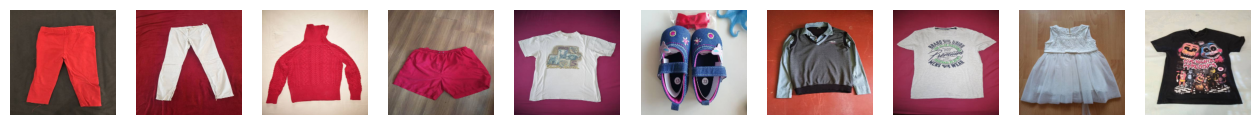

['0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg', '0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg', '0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg', '0a1955a3-c4c5-4141-8a72-afbcf92d0dfa.jpg', '0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg', '0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg', '0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg', '0add1694-17d0-46ec-a9fc-900da252af41.jpg', '0b5f7f85-fa44-4406-91ed-6b730e4b6fa1.jpg', '0b55a8e8-0087-4c19-8729-b872718ff5ae.jpg']


In [7]:
def search_by_style(image_style_embeddings, images, reference_image, max_results=10, ):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))

    img_list=[]
    for i, img in enumerate(sorted_neighbors[:max_results]):
        img_list.append(img[0])
        print(img[0])
        
        ax[i].imshow(images[img[0]])
        ax[i].set_axis_off()
        

    plt.show()
    print(img_list)
  

# images mostly match the reference style, although not perfectly
search_by_style(image_style_embeddings, images, '0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg')



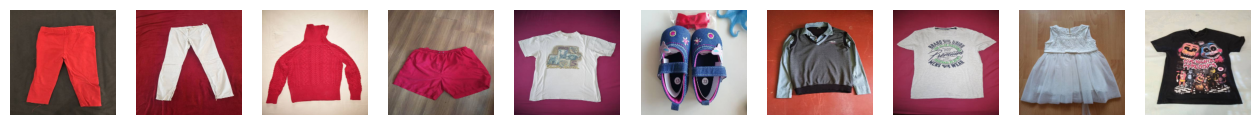

In [8]:

def search_by_style(image_style_embeddings, images, reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))

    img_list=[]
    for i, img in enumerate(sorted_neighbors[:max_results]):
        img_list.append(img[0])
        
        
        ax[i].imshow(images[img[0]])
        ax[i].set_axis_off()
    
    
    return img_list

image_list=search_by_style(image_style_embeddings, images, '0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg')




[['0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg', '0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg', '0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg', '0a1955a3-c4c5-4141-8a72-afbcf92d0dfa.jpg', '0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg', '0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg', '0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg', '0add1694-17d0-46ec-a9fc-900da252af41.jpg', '0b5f7f85-fa44-4406-91ed-6b730e4b6fa1.jpg', '0b55a8e8-0087-4c19-8729-b872718ff5ae.jpg'], ['0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg', '0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg', '0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg', '0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg', '0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg', '0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg', '0add1694-17d0-46ec-a9fc-900da252af41.jpg', '0a1955a3-c4c5-4141-8a72-afbcf92d0dfa.jpg', '0b5f7f85-fa44-4406-91ed-6b730e4b6fa1.jpg', '0b55a8e8-0087-4c19-8729-b872718ff5ae.jpg'], ['0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg', '0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg', '0b1cc7a6-be78-45e6-be22-2

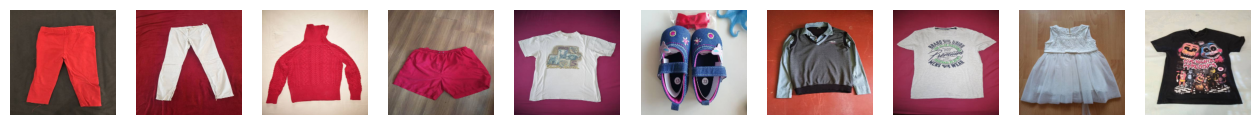

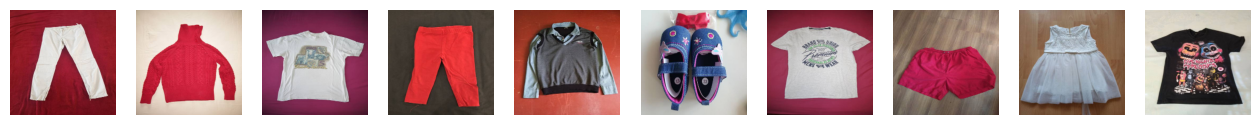

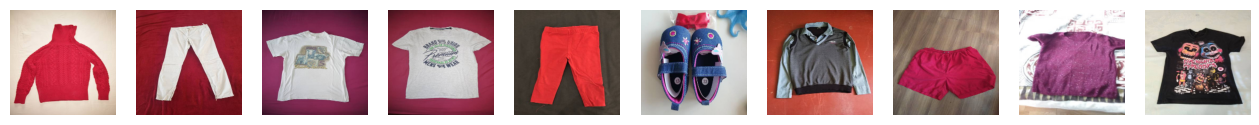

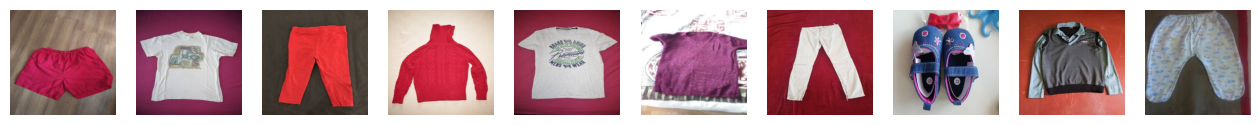

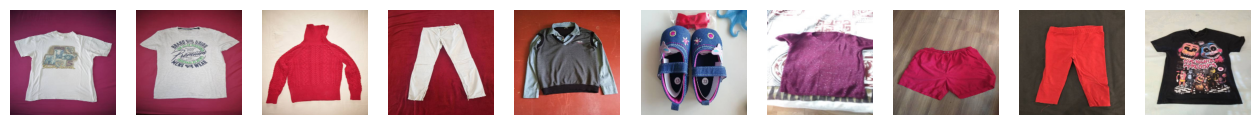

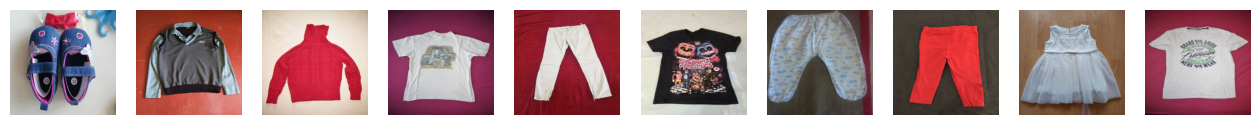

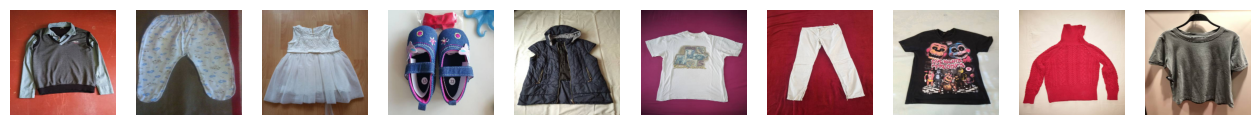

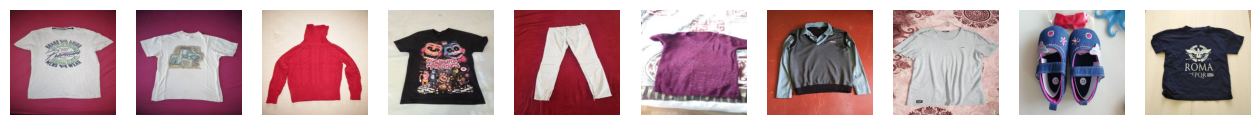

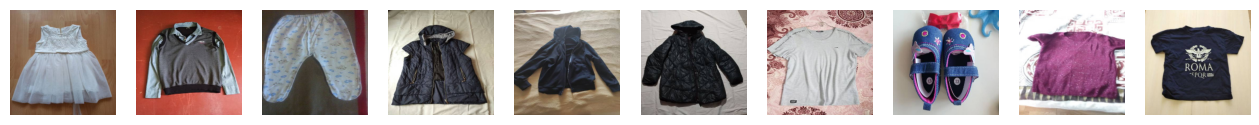

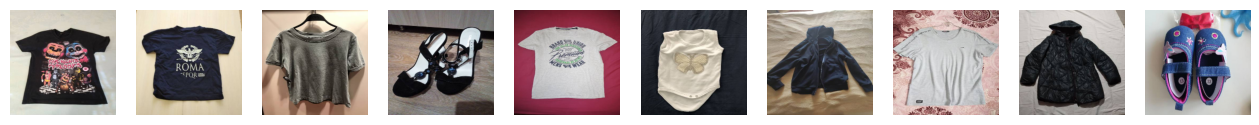

In [9]:
final_list=[]
for i in image_list:
    m_list=search_by_style(image_style_embeddings, images, i)
    final_list.append(m_list)

print (final_list)

In [10]:
from pandas.core.frame import DataFrame
df_final=DataFrame(final_list)

df_final

0  \
0  0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg   
1  0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg   
2  0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg   
3  0a1955a3-c4c5-4141-8a72-afbcf92d0dfa.jpg   
4  0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg   
5  0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg   
6  0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg   
7  0add1694-17d0-46ec-a9fc-900da252af41.jpg   
8  0b5f7f85-fa44-4406-91ed-6b730e4b6fa1.jpg   
9  0b55a8e8-0087-4c19-8729-b872718ff5ae.jpg   

                                          1  \
0  0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg   
1  0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg   
2  0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg   
3  0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg   
4  0add1694-17d0-46ec-a9fc-900da252af41.jpg   
5  0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg   
6  0a2668d3-e42a-4f46-bb7f-01cc409c1839.jpg   
7  0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg   
8  0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg   
9  0b7f4987-34e4-4c85-9f28-35e04ae78ece.jpg   

                                          2  \
0  0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg   
1  0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg   
2  0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg   
3  0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg   
4  0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg   
5  0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg   
6  0b5f7f85-fa44-4406-91ed-6b730e4b6fa1.jpg   
7  0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg   
8  0a2668d3-e42a-4f46-bb7f-01cc409c1839.jpg   
9  0af4203f-8998-4719-92fe-65c14a6b6093.jpg   

                                          3  \
0  0a1955a3-c4c5-4141-8a72-afbcf92d0dfa.jpg   
1  0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg   
2  0add1694-17d0-46ec-a9fc-900da252af41.jpg   
3  0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg   
4  0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg   
5  0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg   
6  0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg   
7  0b55a8e8-0087-4c19-8729-b872718ff5ae.jpg   
8  00a1b7a8-217d-45bf-93a8-86db0bdf9d9d.jpg   
9  0a30baec-1938-47c5-b495-68a51701b43d.jpg   

                                          4  \
0  0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg   
1  0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg   
2  0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg   
3  0add1694-17d0-46ec-a9fc-900da252af41.jpg   
4  0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg   
5  0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg   
6  00a1b7a8-217d-45bf-93a8-86db0bdf9d9d.jpg   
7  0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg   
8  0b0457d9-32f9-4b34-915d-017e5525d9f6.jpg   
9  0add1694-17d0-46ec-a9fc-900da252af41.jpg   

                                          5  \
0  0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg   
1  0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg   
2  0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg   
3  0b20fabe-a5f2-4549-bbb2-504ee53dc89d.jpg   
4  0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg   
5  0b55a8e8-0087-4c19-8729-b872718ff5ae.jpg   
6  0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg   
7  0b20fabe-a5f2-4549-bbb2-504ee53dc89d.jpg   
8  0a86d893-93f1-4a52-8c42-07bb9f439833.jpg   
9  00ac820c-c5f3-48c1-a4b3-a8b66b06a1aa.jpg   

                                          6  \
0  0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg   
1  0add1694-17d0-46ec-a9fc-900da252af41.jpg   
2  0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg   
3  0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg   
4  0b20fabe-a5f2-4549-bbb2-504ee53dc89d.jpg   
5  0a2668d3-e42a-4f46-bb7f-01cc409c1839.jpg   
6  0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg   
7  0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg   
8  0aa095c3-9d4d-4416-8788-82655af859a8.jpg   
9  0b0457d9-32f9-4b34-915d-017e5525d9f6.jpg   

                                          7  \
0  0add1694-17d0-46ec-a9fc-900da252af41.jpg   
1  0a1955a3-c4c5-4141-8a72-afbcf92d0dfa.jpg   
2  0a1955a3-c4c5-4141-8a72-afbcf92d0dfa.jpg   
3  0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg   
4  0a1955a3-c4c5-4141-8a72-afbcf92d0dfa.jpg   
5  0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg   
6  0b55a8e8-0087-4c19-8729-b872718ff5ae.jpg   
7  0aa095c3-9d4d-4416-8788-82655af859a8.

In [148]:
import json
df_result = df_final.to_json(orient="split")
json_result = json.loads(df_result)
json.dumps(json_result, indent=4)  
json_result

{'columns': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'data': [['0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg',
   '0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg',
   '0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg',
   '0a1955a3-c4c5-4141-8a72-afbcf92d0dfa.jpg',
   '0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg',
   '0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg',
   '0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg',
   '0add1694-17d0-46ec-a9fc-900da252af41.jpg',
   '0b5f7f85-fa44-4406-91ed-6b730e4b6fa1.jpg',
   '0b55a8e8-0087-4c19-8729-b872718ff5ae.jpg'],
  ['0ad5bfb5-0f2b-4396-8c05-39ca0a9a2960.jpg',
   '0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg',
   '0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg',
   '0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg',
   '0b7dc2e9-a9e9-46ed-b4e2-8b91e1e720b0.jpg',
   '0a5d2669-3f7f-4350-9f1b-42204b0a9706.jpg',
   '0add1694-17d0-46ec-a9fc-900da252af41.jpg',
   '0a1955a3-c4c5-4141-8a72-afbcf92d0dfa.jpg',
   '0b5f7f85-fa44-4406-91ed-6b730e4b6fa1.jpg',
   '0b55a8e8

In [137]:
from elasticsearch import Elasticsearch, helpers
import configparser


config = configparser.ConfigParser()
config.read('/Users/jiaohongmei/info7374/ElasticSearch/example.ini')


['/Users/jiaohongmei/info7374/ElasticSearch/example.ini']

In [138]:
es = Elasticsearch(
    cloud_id=config['ELASTIC']['cloud_id'],
    basic_auth=(config['ELASTIC']['user'], config['ELASTIC']['password'])
)


In [139]:
es.info()


ObjectApiResponse({'name': 'instance-0000000000', 'cluster_name': '8a7fc3be2ee340bab6d520c0af38282b', 'cluster_uuid': 'ysstMC4hRg2bZkITFV3Dsw', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [140]:
es.ping()

True

In [ ]:
Settings ={
    "settings":{
        
    }
    "mappings":{
        
    }
}

In [143]:
df_final.isna().sum()
df_final.shape

(10, 10)